## Ukraine Russia war Twitter entity recognition and sentiment analysis

In [7]:
# https://quadlayers.com/display-code-in-wordpress/
# import libraries
!python -m spacy download en_core_web_md
!python -m textblob.download_corpora

import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from textblob import TextBlob
import matplotlib.pyplot as plt

import time # for testing function speed
import numpy as np
from datetime import datetime
from deep_translator import GoogleTranslator
import re

#import os
import csv
import gzip

nlp = spacy.load('en_core_web_md')

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/42.8 MB 38.6 kB/s eta 0:18:27
     --------------------------------------- 0.1/42.8 MB 206.9 kB/s eta 0:03:27
     --------------------------------------- 0.1/42.8 MB 249.8 kB/s eta 0:02:51
     --------------------------------------- 0.1/42.8 MB 327.9 kB/s eta 0:02:11
     --------------------------------------- 0.2/42.8 MB 429.5 kB/s eta 0:01:40
     --------------------------------------- 0.3/42.8 MB 593.9 kB/s eta 0:01:12
     -----


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


[nltk_data] Downloading package brown to C:\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to C:\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to C:\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [8]:
# get files
path='C:/Users/alexd/Documents/ukraine_war_analysis/twitter/20230201_UkraineCombinedTweetsDeduped.csv.gzip'
data0 = pd.read_csv(path, compression='gzip')

In [11]:
# remove irrelevant columns, show the final data ready for the analysis
data0=pd.DataFrame(data=data0,columns=['username', 'text', 'totaltweets','followers', 'location', 'extractedts'])
data0['text'].dropna()
data_test = data0.head(1000)
data_test.head()

,username,text,totaltweets,followers,location,extractedts
0,1MedyaNews,"📌 ""I consider it absolutely logical that any f...",5311,3192,"Kurdistan, Worldwide",2023-02-01 08:38:08.838942
1,queen_ukraine,Ukraine War: Inside the battle for Bakhmut\n#c...,14540,46,NaN,2023-02-01 07:17:46.132719
2,isciences,3-month #water anomalies forecast January 2023...,7972,1301,"Ann Arbor, MI, USA",2023-02-01 08:38:08.827016
3,aaanewsworld,◆F-2戦闘機 F-2A/B \n米国のF-16を、日本の運用の考え方や地理的な特性に合わせ...,341,5,"大阪 Osaka, Tokyo, JAPAN, ASIA",2023-02-01 10:57:38.082721
4,Caribvibetv,"Friday, Feb 3/23 at 8PM @OakvilleCentre presen...",2716,2553,Canada,2023-02-01 01:11:03.853106


In [12]:
# translate to english and remove emojis
def rmv_emoji_and_trans_to_en(data, rmv_stopwords=False):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            "]+", flags=re.UNICODE)
    store = pd.DataFrame({'username': [], 'text': [], 'totaltweets': [], 'followers': [], 'location': [], 'extractedts': []})
    for _, row in data.iterrows():
        text = emoji_pattern.sub(r'', row['text'])
        text = GoogleTranslator(source='auto', target='en').translate(text)
        
        if rmv_stopwords:
            stopwords = spacy.lang.en.stop_words.STOP_WORDS
            doc = nlp(text)
            text = ' '.join([word for word in doc if not word.is_stop])
        
        store2 = pd.DataFrame({
            'username': row['username'], 
            'text': text, 
            'totaltweets': row['totaltweets'], 
            'followers': row['followers'], 
            'location': row['location'], 
            'extractedts': pd.to_datetime(data0['extractedts']).dt.strftime('%d/%m/%Y')
        }, index=[0])
        store = pd.concat([store, store2])
    return store

data_en = rmv_emoji_and_trans_to_en(data_test)
data_en.head()

,username,text,totaltweets,followers,location,extractedts
0,1MedyaNews,"""I consider it absolutely logical that any fur...",5311.0,3192.0,"Kurdistan, Worldwide",01/02/2023
0,queen_ukraine,Ukraine War: Inside the battle for Bakhmut\n#c...,14540.0,46.0,NaN,01/02/2023
0,isciences,3-month #water anomalies forecast January 2023...,7972.0,1301.0,"Ann Arbor, MI, USA",01/02/2023
0,aaanewsworld,◆F-2 fighter F-2A/B\nA fighter developed joint...,341.0,5.0,"大阪 Osaka, Tokyo, JAPAN, ASIA",01/02/2023
0,Caribvibetv,"Friday, Feb 3/23 at 8PM @OakvilleCentre presen...",2716.0,2553.0,Canada,01/02/2023


In [13]:
# sentiment analysis 
# https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis
# https://stackabuse.com/python-for-nlp-introduction-to-the-textblob-library/
def sentiment(data):
    store = []
    for row in data.itertuples():
        testimonial = TextBlob(row.text)
        store.append({'username':row.username, 
                      'text':row.text, 
                      'totaltweets':int(row.totaltweets), 
                      'followers':int(row.followers), 
                      'location':row.location, 
                      'extractedts':row.extractedts,
                      'polarity': testimonial.sentiment.polarity })
    return pd.DataFrame(store)

data_sentiment = sentiment(data_en)   
data_sentiment.head()

,username,text,totaltweets,followers,location,extractedts,polarity
0,1MedyaNews,"""I consider it absolutely logical that any fur...",5311,3192,"Kurdistan, Worldwide",01/02/2023,0.180000
1,queen_ukraine,Ukraine War: Inside the battle for Bakhmut\n#c...,14540,46,NaN,01/02/2023,0.000000
2,isciences,3-month #water anomalies forecast January 2023...,7972,1301,"Ann Arbor, MI, USA",01/02/2023,0.000000
3,aaanewsworld,◆F-2 fighter F-2A/B\nA fighter developed joint...,341,5,"大阪 Osaka, Tokyo, JAPAN, ASIA",01/02/2023,0.266667
4,Caribvibetv,"Friday, Feb 3/23 at 8PM @OakvilleCentre presen...",2716,2553,Canada,01/02/2023,-0.166667


In [14]:
def get_entities(data):
    def extract_entities(text):
        # IMPROVE ALSO STORE HASTAGS (ALWAYS START WITH #, ONE TEXT STRING)
        # Extract entities from text
        doc = nlp(text)
        entities = {}
        for ent in doc.ents:
            if ent.label_ in ['GPE', 'ORG', 'PERSON']:
                if ent.label_ not in entities:
                    entities[ent.label_] = set()
                entities[ent.label_].add(ent.text.lower())
        return entities

    data['entities'] = data['text'].apply(extract_entities)
    # Convert the entities dictionary to separate columns in the DataFrame
    data = pd.concat([data, data['entities'].apply(pd.Series, dtype='object')], axis=1)
    data.drop(columns=['entities'], inplace=True)
    return data

dataset_entities = get_entities(data_sentiment) 
dataset_entities.head()

,username,text,totaltweets,followers,location,extractedts,polarity,GPE,PERSON,ORG
0,1MedyaNews,"""I consider it absolutely logical that any fur...",5311,3192,"Kurdistan, Worldwide",01/02/2023,0.180000,"{russia, syria, turkey, iran}",{sergey lavrov},NaN
1,queen_ukraine,Ukraine War: Inside the battle for Bakhmut\n#c...,14540,46,NaN,01/02/2023,0.000000,"{germany, ukraine}",NaN,{bakhmut}
2,isciences,3-month #water anomalies forecast January 2023...,7972,1301,"Ann Arbor, MI, USA",01/02/2023,0.000000,"{russia, tajikistan}",{centralasia},{uralmountains}
3,aaanewsworld,◆F-2 fighter F-2A/B\nA fighter developed joint...,341,5,"大阪 Osaka, Tokyo, JAPAN, ASIA",01/02/2023,0.266667,"{russia, japan, ukraine, the united states}",NaN,"{ukrainerussia, f-2, f-2a/b}"
4,Caribvibetv,"Friday, Feb 3/23 at 8PM @OakvilleCentre presen...",2716,2553,Canada,01/02/2023,-0.166667,"{canada, beaudixon, oakville, oakvillecentre}","{ontario https://t.co/tj5t9htxox, blackpeople}","{spirit, @beauslips, legacy of black music}"


final dataset:
- column 1: the tweet
- columns 2: amount of followers
- column 3: total tweets
- column 4: date of the tweet
- column 5: sentiment for the tweet
- column 6 - x: columns each one for an entity type (person, event, etc)

-
- maybe more relevant (location of the tweet?)


In [88]:
data_entities.iloc[0]['text']

'"i consider it absolutely logical that any further communication on bringing relations between #turkey and #syria back to normal will also involve #russia and #iran," said russia’s top diplomat sergey lavrov.  https://t.co/tmw1rgh6b4'

In [121]:
# speed test
print('rows: ' + str(len(data_test.index)))
start = time.time()
data_en = rmv_emoji_and_trans_to_en(data_test)
end1 = time.time()
print('rmv_emoji_and_trans_to_en:')
print(end1 - start)

start = time.time()
data_sentiment = sentiment(data_en)
end2 = time.time()
print('sentiment: ')
print(end2 - start)

start = time.time()
get_entities(data_sentiment) 
end3 = time.time()
print('get_entities: ')
print(end3 - start)
total_time = end1 + end2 + end3
print('-------------')
print('total time: ')
print(total_time/100000000)

rows: 100
rmv_emoji_and_trans_to_en:
38.704508543014526
sentiment: 
0.02500438690185547
get_entities: 
0.8486604690551758
-------------
total time: 
5.0317193992783595


In [108]:
start = time.time()
print("hello")
end = time.time()
print(end - start)

get_entities(sentiment(rmv_emoji_and_trans_to_en(data_test)))

,username,text,totaltweets,followers,location,extractedts,polarity,GPE,PERSON,ORG
0,1MedyaNews,"""I consider it absolutely logical that any fur...",5311,3192,"Kurdistan, Worldwide",01/02/2023,0.180000,"{iran, turkey, russia, syria}",{sergey lavrov},NaN
1,queen_ukraine,Ukraine War: Inside the battle for Bakhmut\n#c...,14540,46,NaN,01/02/2023,0.000000,"{ukraine, germany}",NaN,{bakhmut}
2,isciences,3-month #water anomalies forecast January 2023...,7972,1301,"Ann Arbor, MI, USA",01/02/2023,0.000000,"{tajikistan, russia}",{centralasia},{uralmountains}
3,aaanewsworld,◆F-2 fighter F-2A/B\nA fighter developed joint...,341,5,"大阪 Osaka, Tokyo, JAPAN, ASIA",01/02/2023,0.266667,"{russia, ukraine, japan, the united states}",NaN,"{f-2, f-2a/b, ukrainerussia}"
4,Caribvibetv,"Friday, Feb 3/23 at 8PM @OakvilleCentre presen...",2716,2553,Canada,01/02/2023,-0.166667,"{oakville, canada, beaudixon, oakvillecentre}","{ontario https://t.co/tj5t9htxox, blackpeople}","{@beauslips, legacy of black music, spirit}"
...,...,...,...,...,...,...,...,...,...,...
95,TheWizardOfG,Ayo #NATO and #NAFO what is going on fellas? U...,801,7,54 68 65 20 4d 61 74 72 69 78,01/02/2023,0.500000,{ukraine},"{nafo, 🤔🧐\n\nwho}",{ayo #nato}
96,louscrews,#NATO has been involved in hybrid war against ...,6925,117,New New York,01/02/2023,0.150000,"{ukraine, russia, moscow}",{lavrov},{nato}
97,GosnDisciplina,@walter_report You cannot take one house witho...,2700,126,Belgrade,01/02/2023,0.000000,NaN,NaN,NaN
98,skalska_o,"The mood, or rather the state, is such that I ...",1655,286,Львів,01/02/2023,0.000000,NaN,{ros},NaN


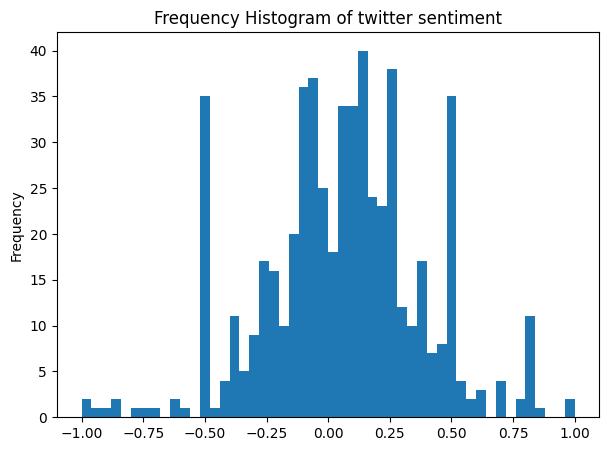

In [169]:
removed_zero = dataset_entities[dataset_entities.iloc[:,6] != 0]
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
x = removed_zero['polarity']
plt.hist(x, bins=50)
plt.gca().set(title='Frequency Histogram of twitter sentiment', ylabel='Frequency');

In [161]:
dataset_entities[dataset_entities.iloc[:,6]>= 0.3 ] 
dataset_entities[dataset_entities.iloc[:,6]<= -0.55 ] 

,username,text,totaltweets,followers,location,extractedts,polarity,GPE,PERSON,ORG
255,grandmaster_pip,While our mainstream media is still rushing li...,250,643,Hauptstadt Berlin,01/02/2023,-0.6250,"{usa, barbarked, ukraine}",NaN,{rand corporation}
350,DotNewsUpdates,Cold temperatures to end soon for Calgary and ...,46874,51,WorldWide,01/02/2023,-0.6000,"{calgary, canada}",NaN,NaN
484,HugoBor73884636,The Yankees came to Russia to film the PCM Wag...,35735,3205,"Viamão, RS, Brasil",01/02/2023,-0.8750,{russia},{kranodar},"{yankees, pcm wagner}"
485,IamOSFA,What say U @POTUS @SecBlinken @jensstoltenberg...,1377,17,NaN,01/02/2023,-0.9000,NaN,"{putin, @jensstoltenberg, @erinburnett https:/...",NaN
599,kumr00,Horrible Footage!! Elite Ukrainian troops brut...,17835,144,سلطنة عمان,01/02/2023,-0.6250,"{ukraine, germany}","{bakhmut, bakhmut\n https://t.co/fyh9hshjkz}",NaN
681,AmoneBoj,"Ukraine war video footage, Drone Attack, Russi...",5845,11,NaN,01/02/2023,-0.8750,"{odesa, canada, russia, germany, ukraine}",{bakhmut\n https://t.co/zmhxxboj6h},"{bakhmut, brutal attack\n #}"
721,AmoneBoj,Bakhmut. Horrible Footage! #shorts #warinukrai...,5888,12,NaN,01/02/2023,-1.0000,"{canada, ukraine, germany}",{bakhmut\n https://t.co/pdfvqernff},{bakhmut}
742,yusr18413764,INSANE UNSEEN Trench Combat Footage - Ukraine ...,6403,35,NaN,01/02/2023,-1.0000,"{ukraine, germany}",NaN,NaN
752,SirrK,V V Ukraine Rush Busters\n\n:(\n\n.@cspanwj .@...,277486,1782,cyberspace,01/02/2023,-0.7500,{usa},{https://t.co/u9popcim7p},{neda}
853,NewsExplorerFr,#Ukraine “Very dangerous people” – Wagner conv...,13968,15,France,01/02/2023,-0.7800,{ukraine},{wagner},NaN


In [15]:
# example code: how to measure function run time.
start = time.time()
get_entities(data_sentiment) 
end3 = time.time()
print('get_entities: ')
print(end3 - start)

get_entities: 
13.599030017852783
